## 1. Carga y Limpieza de Datos de Crímenes

En esta sección cargamos los datos de delitos, realizamos una limpieza inicial y filtramos únicamente los robos a transeúntes en vía pública con y sin violencia.

In [1]:
from functools import reduce
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as sg
import seaborn as sns
import numpy as np

crimen = pd.read_csv('delitos.csv', skiprows=1)
crimen.replace('GUSTAVO A MADERO', 'GUSTAVO A. MADERO', inplace=True)
print(f"Dimensiones del DataFrame: {crimen.shape}")

print("Columnas del DataFrame:", crimen.columns.tolist())
print("\nConteo de tipos de delitos:")
print(crimen['DELITO'].value_counts())

crimen = crimen[crimen['DELITO'] == 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA']
print(f"Dimensiones después del filtrado: {crimen.shape}")
robos_alcaldia = crimen.groupby('ALCALDÍA HECHOS')['DELITO'].count()
print("Robos por Alcaldía:")
print(robos_alcaldia)


Dimensiones del DataFrame: (32196, 19)
Columnas del DataFrame: ['ID', 'ID_CI', 'FECHA DE INICIO', 'HORA DE INICIO', 'CT - INICIO AP', 'TIPO IMPACTO', 'DELITO', 'MODALIDAD - DELITO', 'FECHA DE LOS HECHOS', 'HORA DE LOS HECHOS', 'CALLE 1 HECHOS', 'CALLE 2 HECHOS', 'COLONIA HECHOS', 'ALCALDÍA HECHOS', 'CT HECHOS', 'COORD X', 'COORD Y', 'OBSERVACIÓN', 'Unnamed: 18']

Conteo de tipos de delitos:
DELITO
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA       10189
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                       10018
ROBO A NEGOCIO CON VIOLENCIA                                3514
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                       2349
VIOLACIÓN                                                   1505
HOMICIDIO DOLOSO                                            1206
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                871
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA        782
ROBO A CASA HABITACIÓN CON VIOLENCIA                         633
ROBO A PASAJER

## 2. Carga y Procesamiento de Datos de Población

Se cargan los datos de población, se agrupan por alcaldía y se combinan con los datos de robos para calcular tasas por 100,000 habitantes.

In [2]:
poblacion = pd.read_csv('poblacion.csv')
poblacion_alcaldia = poblacion.groupby('alcaldia')['poblacion'].sum()
print("Población por Alcaldía:")
print(poblacion_alcaldia)

robos_poblacion_df = pd.DataFrame({
    'robos': robos_alcaldia,
    'poblacion': poblacion_alcaldia
}).dropna()

robos_poblacion_df['tasa_robos'] = (robos_poblacion_df['robos']/robos_poblacion_df['poblacion'])*100000
robos_poblacion_df


Población por Alcaldía:
alcaldia
ALVARO OBREGON             758180
AZCAPOTZALCO               431840
BENITO JUAREZ              434115
COYOACAN                   614319
CUAJIMALPA DE MORELOS      216398
CUAUHTEMOC                 545818
GUSTAVO A. MADERO         1173117
IZTACALCO                  404517
IZTAPALAPA                1835091
LA MAGDALENA CONTRERAS     246385
MIGUEL HIDALGO             408544
MILPA ALTA                 135926
TLAHUAC                    388687
TLALPAN                    692545
VENUSTIANO CARRANZA        443289
XOCHIMILCO                 434406
Name: poblacion, dtype: int64


,robos,poblacion,tasa_robos
ALVARO OBREGON,858,758180.0,113.165739
AZCAPOTZALCO,507,431840.0,117.404594
BENITO JUAREZ,586,434115.0,134.987273
COYOACAN,561,614319.0,91.320633
CUAJIMALPA DE MORELOS,70,216398.0,32.347804
CUAUHTEMOC,1386,545818.0,253.930797
GUSTAVO A. MADERO,983,1173117.0,83.793859
IZTACALCO,458,404517.0,113.221447
IZTAPALAPA,1898,1835091.0,103.428113
LA MAGDALENA CONTRERAS,123,246385.0,49.921870


## 3. Filtrado de Alcaldías de Interés y Limpieza de Coordenadas

Se enfocan los datos en las alcaldías de interés y se asegura la calidad geoespacial al eliminar registros sin coordenadas.


In [3]:
alcaldias_interes = ['CUAUHTEMOC', 'GUSTAVO A. MADERO', 'CUAJIMALPA DE MORELOS']
crimen = crimen[crimen['ALCALDÍA HECHOS'].isin(alcaldias_interes)]
crimen['COORD X'] = pd.to_numeric(crimen['COORD X'], errors='coerce')
crimen['COORD Y'] = pd.to_numeric(crimen['COORD Y'], errors='coerce')
crimen = crimen.dropna(subset=['COORD X','COORD Y'])

robos_alcaldia = crimen.groupby('ALCALDÍA HECHOS')['DELITO'].count()
print("Robos por Alcaldía después del filtrado:")
print(robos_alcaldia)

poblacion = poblacion[poblacion['alcaldia'].isin(alcaldias_interes)]
poblacion_alcaldia = poblacion.groupby('alcaldia')['poblacion'].sum()
print("Población por Alcaldía después del filtrado:")
print(poblacion_alcaldia)

Robos por Alcaldía después del filtrado:
ALCALDÍA HECHOS
CUAJIMALPA DE MORELOS      69
CUAUHTEMOC               1380
GUSTAVO A. MADERO         978
Name: DELITO, dtype: int64
Población por Alcaldía después del filtrado:
alcaldia
CUAJIMALPA DE MORELOS     216398
CUAUHTEMOC                545818
GUSTAVO A. MADERO        1173117
Name: poblacion, dtype: int64


## 4. Análisis Geoespacial

Se genera un mapa base, se incorporan los datos de crímenes como puntos georreferenciados y se filtra el mapa a las alcaldías de interés.

In [4]:
# Ruta al archivo GeoJSON
ruta_geojson = 'mapa.json'

# Carga del mapa base
agebs = gpd.read_file(ruta_geojson)
# Creación de geometrías a partir de coordenadas
crimen['geometry'] = crimen.apply(lambda row: sg.Point(row['COORD X'], row['COORD Y']), axis=1)
crimen_gdf = gpd.GeoDataFrame(crimen, geometry='geometry')

# Asignación del CRS (Sistema de Referencia de Coordenadas)
crimen_gdf.set_crs(agebs.crs, inplace=True)
print("CRS del mapa base:", agebs.crs)
print("CRS de crímenes:", crimen_gdf.crs)

CRS del mapa base: EPSG:4326
CRS de crímenes: EPSG:4326


ERROR 1: PROJ: proj_create_from_database: Open of /home/erik/miniconda3/share/proj failed


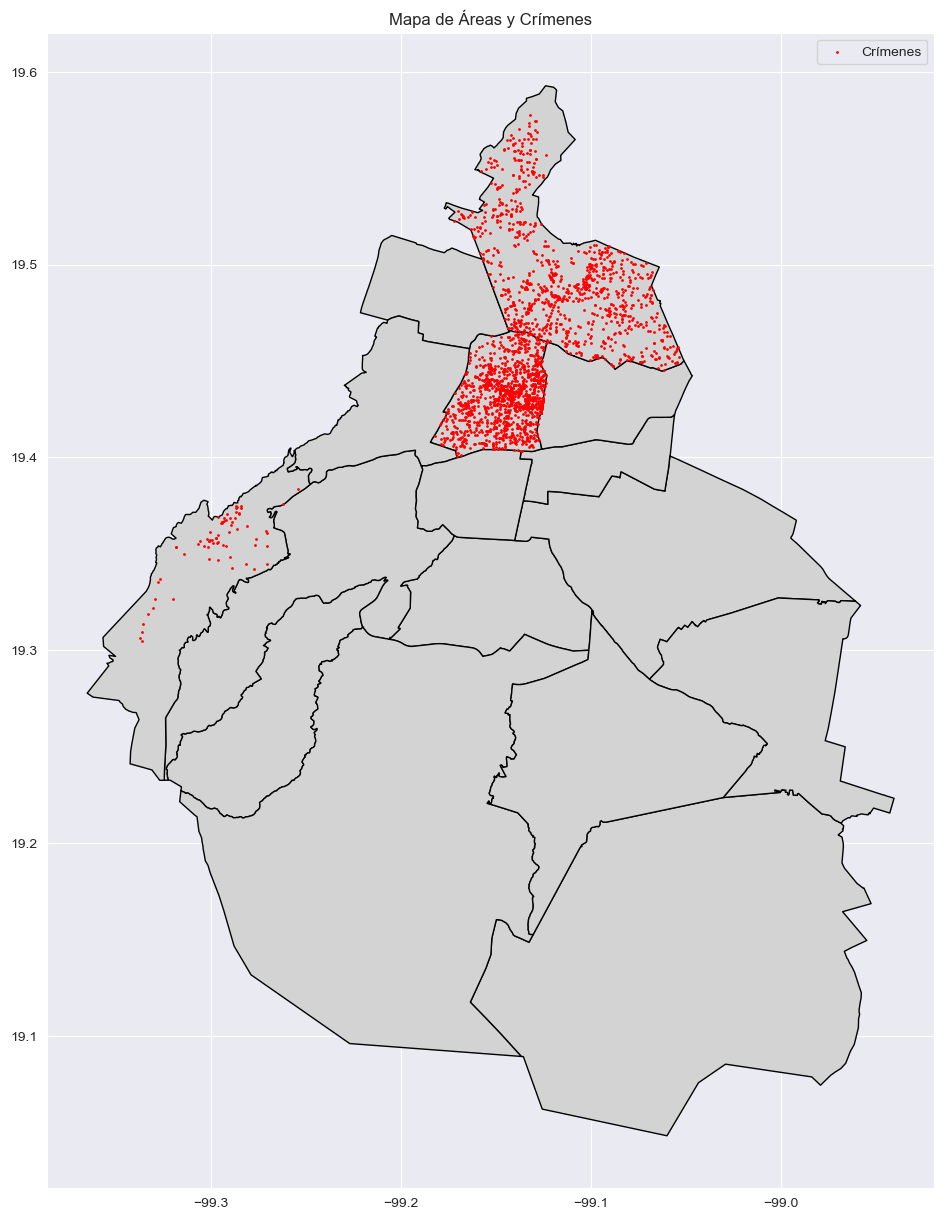

In [5]:
# Configuración de la figura
fig, ax = plt.subplots(figsize=(15, 15))  # Tamaño aumentado para mejor visualización

# Plot del mapa base
agebs.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot de los crímenes
crimen_gdf.plot(ax=ax, markersize=1, color='red', alpha=1, marker='o', label='Crímenes')

# Ajuste de los límites del mapa con un margen
xmin, ymin, xmax, ymax = agebs.total_bounds
margin_x = (xmax - xmin) * 0.05
margin_y = (ymax - ymin) * 0.05
ax.set_xlim(xmin - margin_x, xmax + margin_x)
ax.set_ylim(ymin - margin_y, ymax + margin_y)

# Añadir leyenda y título
plt.legend()
plt.title('Mapa de Áreas y Crímenes')
plt.show()

## 5. Análisis de Variables Independientes

Se incorporan variables como densidad de población, grado de escolaridad, número de escuelas y uso de suelo no residencial. Estas variables pueden influir en la incidencia delictiva.


### 5.1. Densidad de Población

Se calcula la densidad de población (habitantes por km²) para entender su relación con los robos.


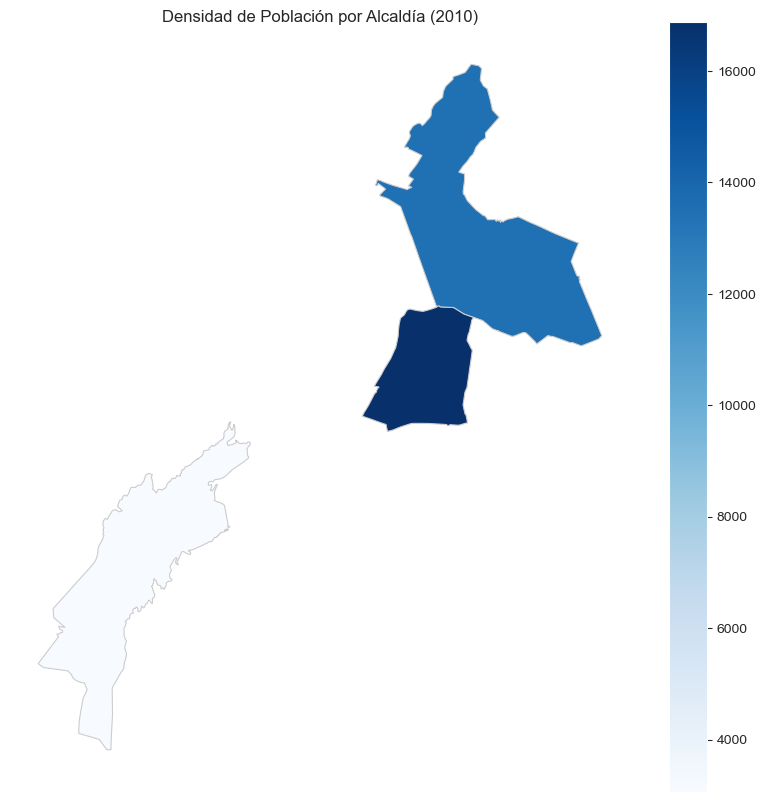

/tmp/ipykernel_40107/796810799.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NOMGEO', y='densidad_poblacion', data=densidad_df, palette='Blues_d')


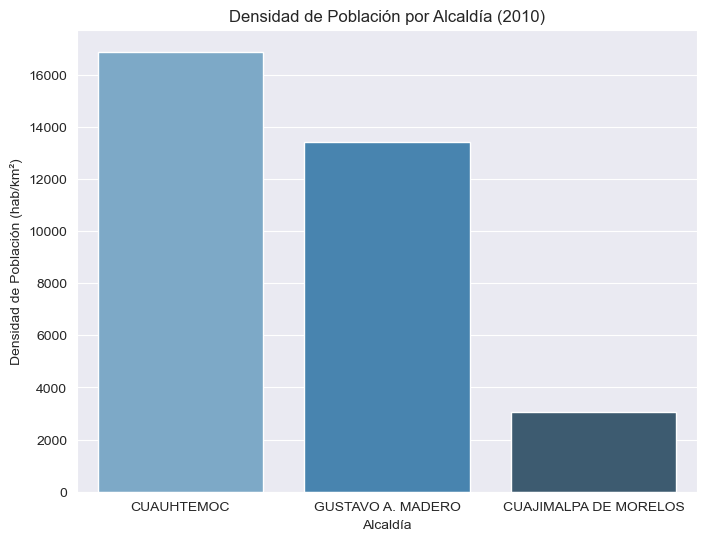

In [6]:
agebs['area_km2'] = agebs['AREA']/100
poblacion_alcaldia_df = poblacion_alcaldia.reset_index()
poblacion_alcaldia_df.columns = ['NOMGEO','poblacion']
densidad_df = agebs[['NOMGEO','area_km2']].merge(poblacion_alcaldia_df, on='NOMGEO')
densidad_df['densidad_poblacion'] = densidad_df['poblacion']/densidad_df['area_km2']
agebs = agebs.merge(densidad_df[['NOMGEO','densidad_poblacion']], on='NOMGEO')

fig, ax = plt.subplots(figsize=(10,10))
agebs.plot(column='densidad_poblacion', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Densidad de Población por Alcaldía (2010)')
plt.axis('off')
plt.show()

plt.figure(figsize=(8,6))
sns.barplot(x='NOMGEO', y='densidad_poblacion', data=densidad_df, palette='Blues_d')
plt.xlabel('Alcaldía')
plt.ylabel('Densidad de Población (hab/km²)')
plt.title('Densidad de Población por Alcaldía (2010)')
plt.show()

### 5.2. Escolaridad

Se analiza el grado de escolaridad promedio en las alcaldías de interés para 2020.

https://planeacion.sep.gob.mx/Doc/Atlas_estados/CDMX.pdf

/tmp/ipykernel_40107/1904838044.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Municipio', y='Grado de escolaridad promedio', data=escolaridad, palette='Blues_d')


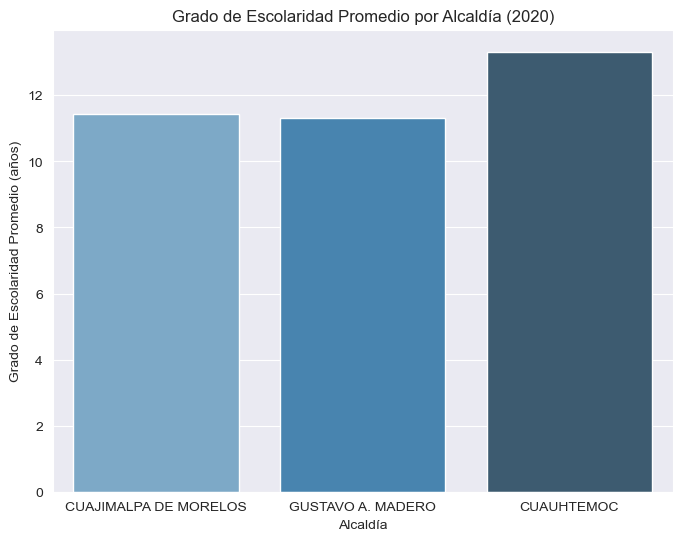

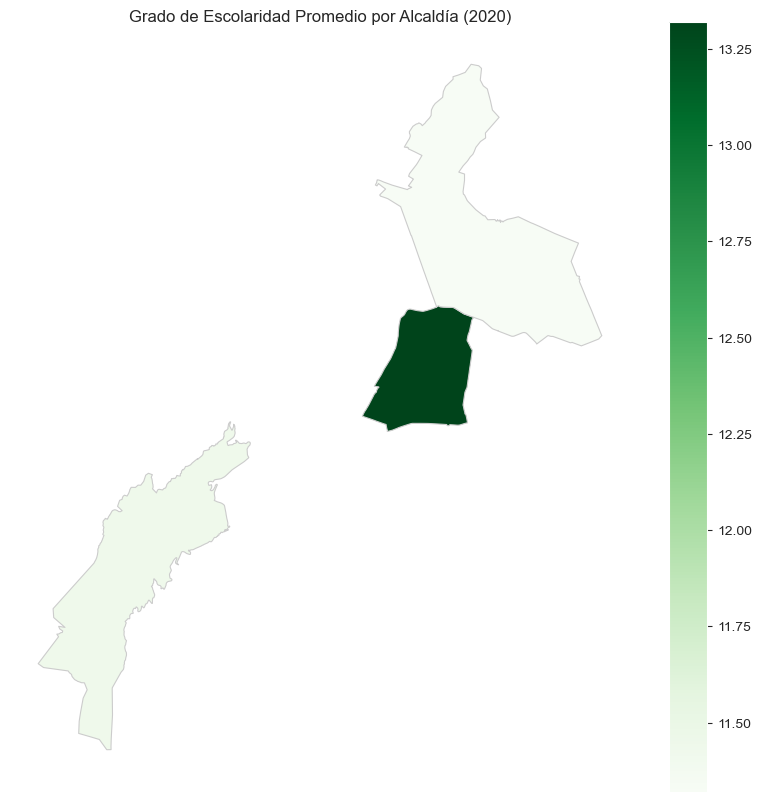

In [7]:
escolaridad = pd.read_csv('escolaridad.csv')
escolaridad = escolaridad[['Municipio', 'Grado de escolaridad promedio']]
escolaridad = escolaridad[escolaridad['Municipio'].isin(alcaldias_interes)]

plt.figure(figsize=(8,6))
sns.barplot(x='Municipio', y='Grado de escolaridad promedio', data=escolaridad, palette='Blues_d')
plt.xlabel('Alcaldía')
plt.ylabel('Grado de Escolaridad Promedio (años)')
plt.title('Grado de Escolaridad Promedio por Alcaldía (2020)')
plt.show()

escolaridad = escolaridad.rename(columns={'Municipio':'NOMGEO'})
agebs = agebs.merge(escolaridad, on='NOMGEO')

fig, ax = plt.subplots(figsize=(10,10))
agebs.plot(column='Grado de escolaridad promedio', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Grado de Escolaridad Promedio por Alcaldía (2020)')
plt.axis('off')
plt.show()


### 5.3. Escuelas Públicas y Privadas

Se calcula la cantidad de escuelas públicas y privadas por alcaldía y se analiza su densidad.

https://datos.cdmx.gob.mx/dataset/escuelas-publicas
https://datos.cdmx.gob.mx/dataset/escuelas-privadas

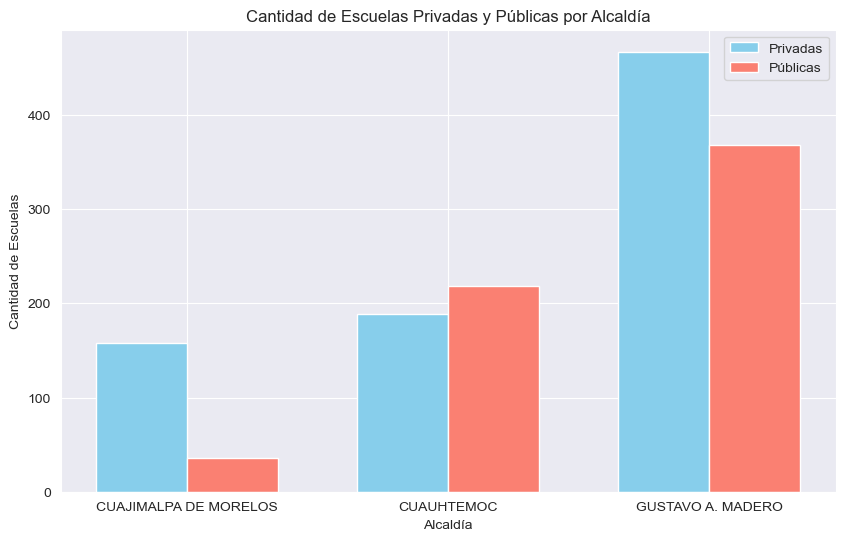

,NOMGEO,densidad_escuelas_privadas,densidad_escuelas_publicas
0,CUAJIMALPA DE MORELOS,2.232841,0.508749
1,CUAUHTEMOC,5.845015,6.741869
2,GUSTAVO A. MADERO,5.344576,4.211572


In [8]:
escuelas_privadas = pd.read_csv('escuelas_privadas.csv')
escuelas_publicas = pd.read_csv('escuelas_publicas.csv')

escuelas_privadas = escuelas_privadas[escuelas_privadas['alcaldia'].isin(alcaldias_interes)]
escuelas_publicas = escuelas_publicas[escuelas_publicas['alcaldia'].isin(alcaldias_interes)]

conteo_privadas = escuelas_privadas.groupby('alcaldia').size().reset_index(name='escuelas_privadas')
conteo_publicas = escuelas_publicas.groupby('alcaldia').size().reset_index(name='escuelas_publicas')
conteo_total_escuelas = pd.merge(conteo_privadas, conteo_publicas, on='alcaldia', how='outer').fillna(0)
conteo_total_escuelas['escuelas_privadas'] = conteo_total_escuelas['escuelas_privadas'].astype(int)
conteo_total_escuelas['escuelas_publicas'] = conteo_total_escuelas['escuelas_publicas'].astype(int)

fig, ax = plt.subplots(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(conteo_total_escuelas))
ax.bar(index, conteo_total_escuelas['escuelas_privadas'], bar_width, color='skyblue', label='Privadas')
ax.bar(index+bar_width, conteo_total_escuelas['escuelas_publicas'], bar_width, color='salmon', label='Públicas')
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels(conteo_total_escuelas['alcaldia'])
ax.set_xlabel('Alcaldía')
ax.set_ylabel('Cantidad de Escuelas')
ax.set_title('Cantidad de Escuelas Privadas y Públicas por Alcaldía')
ax.legend()
plt.show()

conteo_total_escuelas = conteo_total_escuelas.rename(columns={'alcaldia':'NOMGEO'})
conteo_total_escuelas = conteo_total_escuelas.merge(agebs, on='NOMGEO')
conteo_total_escuelas = conteo_total_escuelas[['NOMGEO','escuelas_privadas','escuelas_publicas','area_km2']]
conteo_total_escuelas['densidad_escuelas_privadas'] = conteo_total_escuelas['escuelas_privadas']/conteo_total_escuelas['area_km2']
conteo_total_escuelas['densidad_escuelas_publicas'] = conteo_total_escuelas['escuelas_publicas']/conteo_total_escuelas['area_km2']
conteo_total_escuelas = conteo_total_escuelas[['NOMGEO','densidad_escuelas_privadas','densidad_escuelas_publicas']]
conteo_total_escuelas


### 5.4. Uso de Suelo No Residencial

Se analizan tipos de uso de suelo no residencial, principalmente orientados a comercio y servicios.



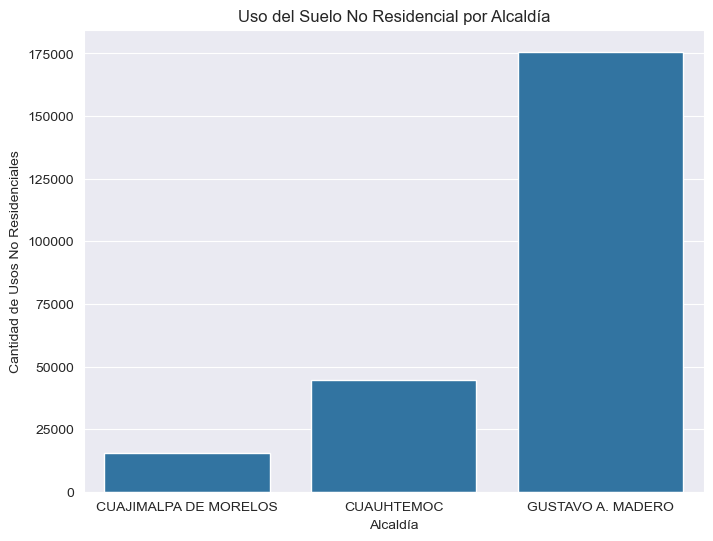

In [9]:
dfUsoDeSuelo = pd.read_csv('usoDeSuelo.csv')
dfUsoDeSuelo = dfUsoDeSuelo[dfUsoDeSuelo['alcaldia'].isin(alcaldias_interes)]
dfUsoDeSuelo = dfUsoDeSuelo.groupby('alcaldia').size().reset_index(name='usoNoResidencial')

plt.figure(figsize=(8,6))
sns.barplot(x='alcaldia', y='usoNoResidencial', data=dfUsoDeSuelo)
plt.xlabel('Alcaldía')
plt.ylabel('Cantidad de Usos No Residenciales')
plt.title('Uso del Suelo No Residencial por Alcaldía')
plt.show()

In [10]:
dfUsoDeSuelo = dfUsoDeSuelo.merge(poblacion_alcaldia.reset_index(), on='alcaldia', how='left')
dfUsoDeSuelo.head()

,alcaldia,usoNoResidencial,poblacion
0,CUAJIMALPA DE MORELOS,15573,216398
1,CUAUHTEMOC,44657,545818
2,GUSTAVO A. MADERO,175701,1173117


In [11]:
dfUsoDeSuelo['usoNoResidencial_100k'] = (dfUsoDeSuelo['usoNoResidencial'] / dfUsoDeSuelo['poblacion']) * 100000
dfUsoDeSuelo = dfUsoDeSuelo[['alcaldia', 'usoNoResidencial_100k']]
dfUsoDeSuelo

,alcaldia,usoNoResidencial_100k
0,CUAJIMALPA DE MORELOS,7196.462075
1,CUAUHTEMOC,8181.664951
2,GUSTAVO A. MADERO,14977.278481


### 5.5. Cámaras de Vigilancia (C5I)

Se considera la distribución de cámaras de vigilancia en las alcaldías de interés.

https://www.infocdmx.org.mx/index.php/2-boletines/5567-dcs-089-17.html


In [12]:
dfCamaras = pd.read_csv('camarasC5I.csv')
dfCamaras = dfCamaras[dfCamaras['Delegación'].isin(alcaldias_interes)]
# dfCamaras = pd.merge(dfCamaras, poblacion_alcaldia, left_on='Delegación', right_on='alcaldia')
# dfCamaras['densidadCamaras'] = 
dfCamaras = dfCamaras.rename(columns = {"Delegación": "alcaldia", "Total Cámaras": "totalCamaras"})
dfCamaras.head()

,alcaldia,totalCamaras
4,CUAJIMALPA DE MORELOS,266
5,CUAUHTEMOC,1639
6,GUSTAVO A. MADERO,1992


In [13]:
dfCamaras = dfCamaras.merge(poblacion_alcaldia.reset_index(), on='alcaldia', how='left')
dfCamaras['camaras_100k'] = (dfCamaras['totalCamaras']/dfCamaras['poblacion'])*100000
dfCamaras = dfCamaras[['alcaldia','camaras_100k']]
dfCamaras

,alcaldia,camaras_100k
0,CUAJIMALPA DE MORELOS,122.921654
1,CUAUHTEMOC,300.283245
2,GUSTAVO A. MADERO,169.804035


# Union datos

In [14]:
robos_poblacion_df = robos_poblacion_df.reset_index()
robos_poblacion_df = robos_poblacion_df[robos_poblacion_df['index'].isin(alcaldias_interes)]
robos_poblacion_df = robos_poblacion_df[['index', 'tasa_robos']]
robos_poblacion_df = robos_poblacion_df.rename(columns = {"index": "alcaldia"})
robos_poblacion_df.head()

,alcaldia,tasa_robos
4,CUAJIMALPA DE MORELOS,32.347804
5,CUAUHTEMOC,253.930797
6,GUSTAVO A. MADERO,83.793859


In [15]:
agebs = agebs[['NOMGEO', 'densidad_poblacion']]
agebs = agebs.rename(columns = {"NOMGEO": "alcaldia"})
agebs

,alcaldia,densidad_poblacion
0,CUAUHTEMOC,16879.971159
1,GUSTAVO A. MADERO,13425.723734
2,CUAJIMALPA DE MORELOS,3058.116394


In [16]:
escolaridad = escolaridad.rename(columns = {"NOMGEO": "alcaldia", "Grado de escolaridad promedio": "escolaridad"})
escolaridad

,alcaldia,escolaridad
3,CUAJIMALPA DE MORELOS,11.44
4,GUSTAVO A. MADERO,11.32
14,CUAUHTEMOC,13.32


In [17]:
conteo_total_escuelas = conteo_total_escuelas.rename(columns = {"NOMGEO": "alcaldia"})
conteo_total_escuelas

,alcaldia,densidad_escuelas_privadas,densidad_escuelas_publicas
0,CUAJIMALPA DE MORELOS,2.232841,0.508749
1,CUAUHTEMOC,5.845015,6.741869
2,GUSTAVO A. MADERO,5.344576,4.211572


In [18]:
dfUsoDeSuelo

,alcaldia,usoNoResidencial_100k
0,CUAJIMALPA DE MORELOS,7196.462075
1,CUAUHTEMOC,8181.664951
2,GUSTAVO A. MADERO,14977.278481


In [19]:
dfCamaras = dfCamaras.rename(columns = {"Delegación": "alcaldia", "Total Cámaras": "totalCamaras"})
dfCamaras

,alcaldia,camaras_100k
0,CUAJIMALPA DE MORELOS,122.921654
1,CUAUHTEMOC,300.283245
2,GUSTAVO A. MADERO,169.804035


In [20]:
dfs = [robos_poblacion_df, agebs, escolaridad, conteo_total_escuelas, dfUsoDeSuelo, dfCamaras]
df = reduce(lambda left, right: pd.merge(left, right, on='alcaldia', how='outer'), dfs)
print(df.columns)
df

Index(['alcaldia', 'tasa_robos', 'densidad_poblacion', 'escolaridad',
       'densidad_escuelas_privadas', 'densidad_escuelas_publicas',
       'usoNoResidencial_100k', 'camaras_100k'],
      dtype='object')


,alcaldia,tasa_robos,densidad_poblacion,escolaridad,densidad_escuelas_privadas,densidad_escuelas_publicas,usoNoResidencial_100k,camaras_100k
0,CUAJIMALPA DE MORELOS,32.347804,3058.116394,11.44,2.232841,0.508749,7196.462075,122.921654
1,CUAUHTEMOC,253.930797,16879.971159,13.32,5.845015,6.741869,8181.664951,300.283245
2,GUSTAVO A. MADERO,83.793859,13425.723734,11.32,5.344576,4.211572,14977.278481,169.804035


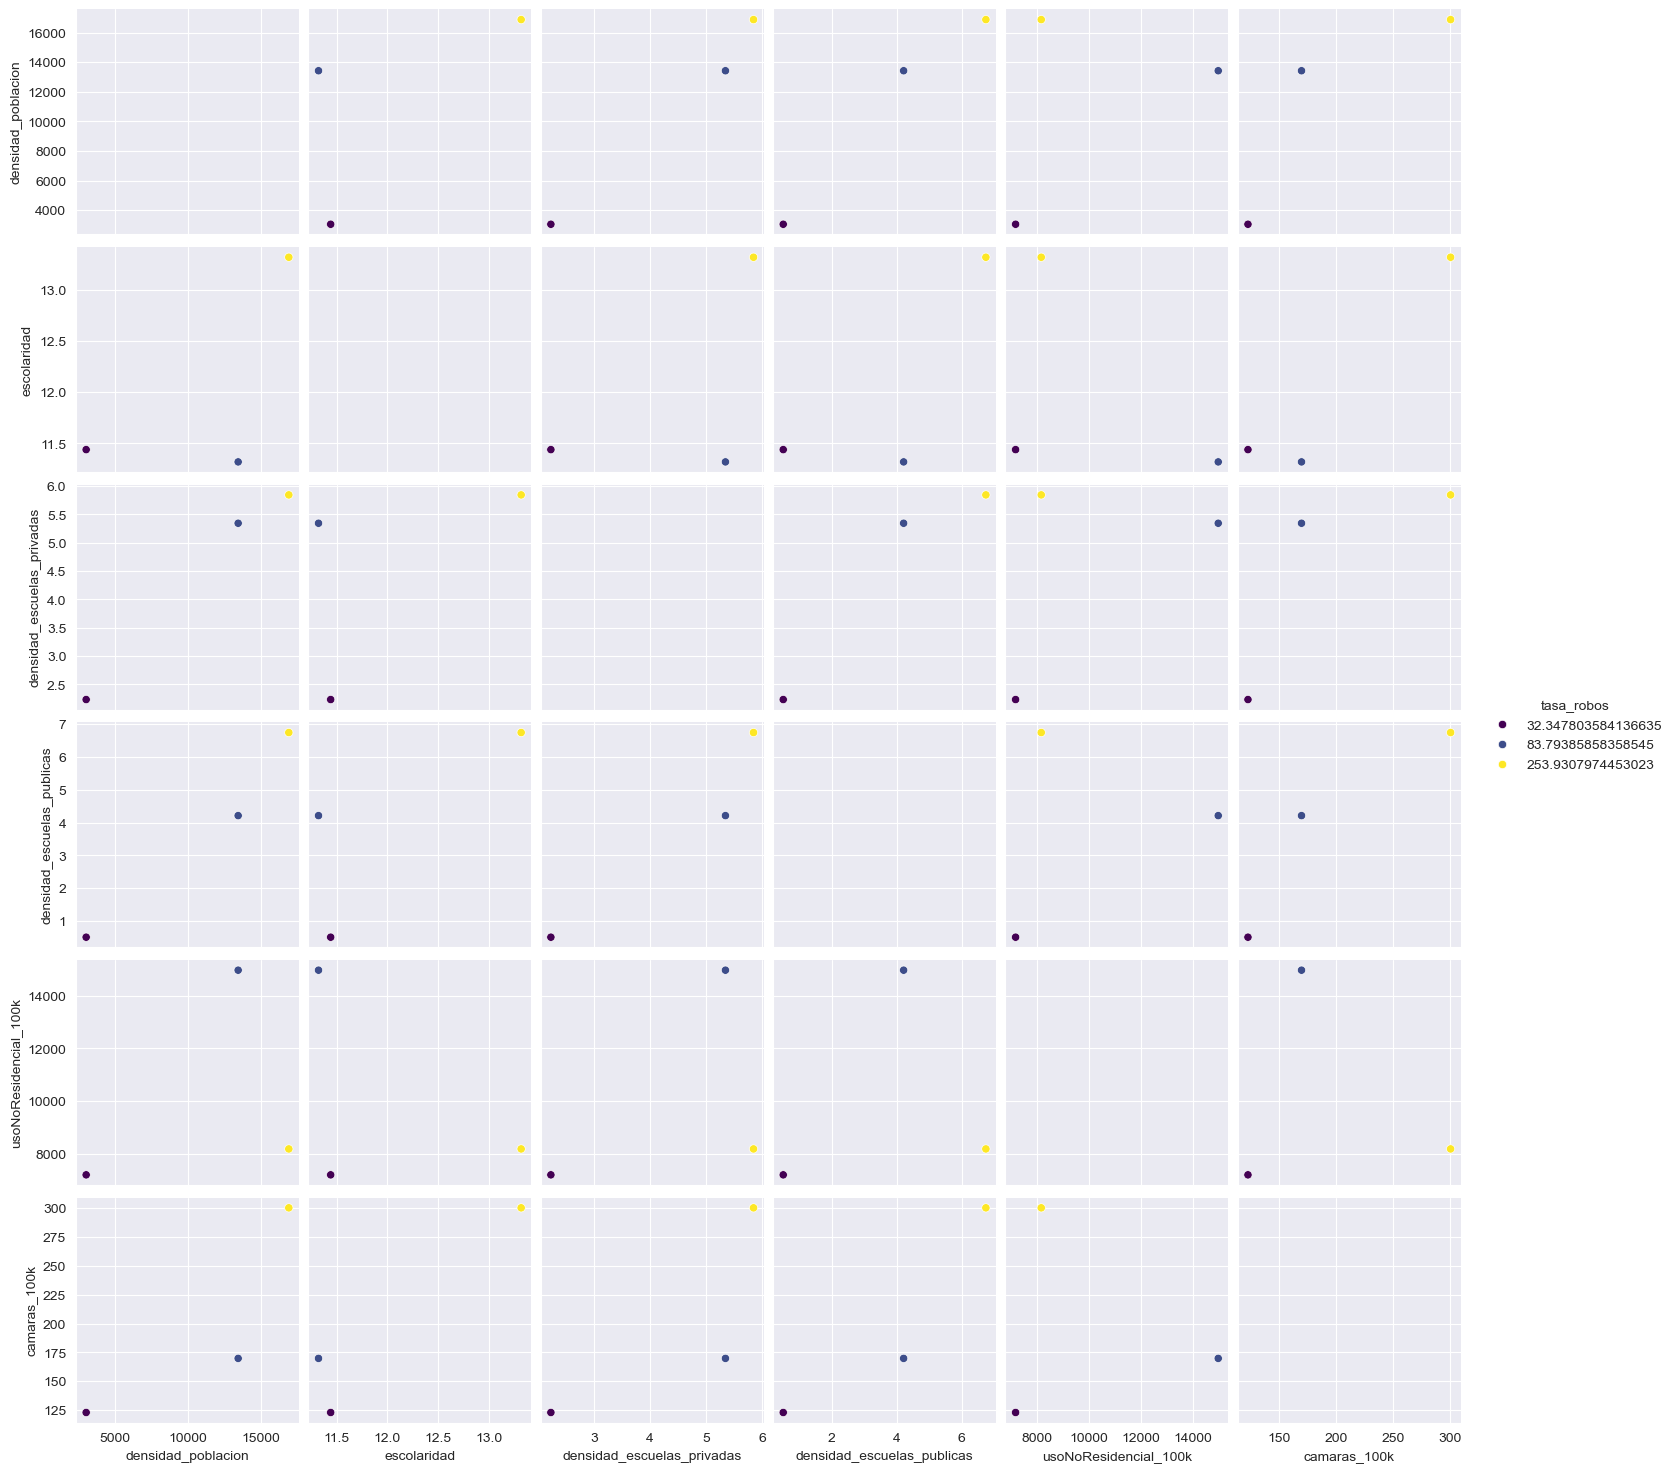

In [23]:
sns.pairplot(df, vars=df.columns[2:], hue='tasa_robos', diag_kind='kde', palette='viridis')
plt.show()